## Import and Settings

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql.functions import col, expm1, abs, avg, lit, round
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

MODEL_PATH = "../../models/regression/random_forest_price_v1"  

DATA_PATH = "../../data/cleaned/regression_data"

## Initialize Spark

In [2]:
spark = SparkSession.builder \
    .appName("Amazon Price Prediction") \
    .config("spark.driver.memory", "8g") \
    .master("local[*]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")


## Load Model and Data

In [3]:
print(f"Loading model from: {MODEL_PATH}...")
loaded_model = PipelineModel.load(MODEL_PATH)
print("Model loaded successfully!")

print(f"Loading data from: {DATA_PATH}...")
df = spark.read.parquet(DATA_PATH)

df = df.withColumn("price", col("price").cast("float")) \
       .filter(col("price") > 0)

_, test_data = df.randomSplit([0.8, 0.2], seed=42)
print(f"Test data count: {test_data.count()} rows")

Loading model from: ../../models/regression/random_forest_price_v1...
Model loaded successfully!
Loading data from: ../../data/cleaned/regression_data...
Test data count: 139938 rows


## Prediction

In [5]:
from pyspark.sql.functions import col, size, length, when

has_array_features = [f.dataType for f in df.schema.fields if f.name == "features"] # checks the data type of the features column and creates a new column features_count
if str(has_array_features[0]).startswith("ArrayType"):
    df = df.withColumn("features_count", size(col("features")))
else:
    if "features_count" not in df.columns and "features" in df.columns:
         df = df.withColumn("features_count", length(col("features")))

In [6]:
required_cols = ["rating_number", "average_rating", "main_category", "price"]

In [7]:
if "features_count" in df.columns: required_cols.append("features_count")
if "desc_len" in df.columns: required_cols.append("desc_len")

df_clean = df.dropna(subset=required_cols)

In [8]:
df_clean = df_clean.withColumn("title_len", length(col("title")))

In [9]:
from pyspark.sql.functions import length, col, count

store_counts = df_clean.groupBy("store").agg(count("*").alias("store_freq"))

In [10]:
df_improved = df_clean.join(store_counts, on="store", how="left")
df_improved = df_improved.na.fill(0, subset=["store_freq", "features_count", "title_len"])

In [11]:
from pyspark.sql.functions import broadcast

df_improved = df_clean.join(broadcast(store_counts), on="store", how="left")

cols_to_fill = ["store_freq", "title_len", "average_rating", "rating_number"]
if "features_count" in df_improved.columns: cols_to_fill.append("features_count")
if "desc_len" in df_improved.columns: cols_to_fill.append("desc_len")

df_improved = df_improved.na.fill(0, subset=cols_to_fill)

df_improved = df_improved.filter(col("title").isNotNull())
df_improved.cache()

DataFrame[store: string, parent_asin: string, title: string, main_category: string, average_rating: double, rating_number: bigint, features: array<string>, description: array<string>, price: float, main_category_label: string, features_count: int, title_len: int, store_freq: bigint]

In [12]:
_, test_data = df_improved.randomSplit([0.8, 0.2], seed=42)

In [15]:
print("Running predictions...")
predictions = loaded_model.transform(test_data)

predictions = predictions.withColumn("predicted_price", col("prediction"))

from pyspark.sql.functions import when
predictions = predictions.withColumn(
    "predicted_price", 
    when(col("predicted_price") < 0, 0.01).otherwise(col("predicted_price"))
)

predictions.select("title", "price", "predicted_price").show(5, truncate=False)

Running predictions...
+-------------------------------------------------------------------------------+------+------------------+
|title                                                                          |price |predicted_price   |
+-------------------------------------------------------------------------------+------+------------------+
|Warhammer 40k Adeptus Mechanicus Codex                                         |22.41 |36.76730296998821 |
|[ST125] 2 Piece VVT-I DOHC Vinyl Sticker JDM Stickers 2JZ Supra Corrolla SILVER|5.99  |28.42215906037421 |
|Analog/Dual Shock Controller - Emerald                                         |57.77 |56.296218500436446|
|Beetle Adventure Racing                                                        |43.98 |53.39299051455483 |
|Wave Race 64 (Japan)                                                           |180.09|53.711804593127695|
+-------------------------------------------------------------------------------+------+------------------+
only 

## Calculate Metrics

In [16]:
evaluator_r2 = RegressionEvaluator(labelCol="price", predictionCol="predicted_price", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

evaluator_rmse = RegressionEvaluator(labelCol="price", predictionCol="predicted_price", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

evaluator_mae = RegressionEvaluator(labelCol="price", predictionCol="predicted_price", metricName="mae")
mae = evaluator_mae.evaluate(predictions)

predictions = predictions.withColumn("abs_diff", abs(col("price") - col("predicted_price")))
predictions = predictions.withColumn("ape", (col("abs_diff") / col("price")) * 100)

mape = predictions.select(avg("ape")).collect()[0][0]

print(f"   MODEL EVALUATION REPORT")
print(f"R² Score:  {r2:.4f}")
print(f"RMSE:      ${rmse:.2f}")
print(f"MAE:       ${mae:.2f}")
print(f"MAPE:      {mape:.2f}%")

   MODEL EVALUATION REPORT
R² Score:  0.1024
RMSE:      $183.06
MAE:       $59.17
MAPE:      351.80%


## Visualization

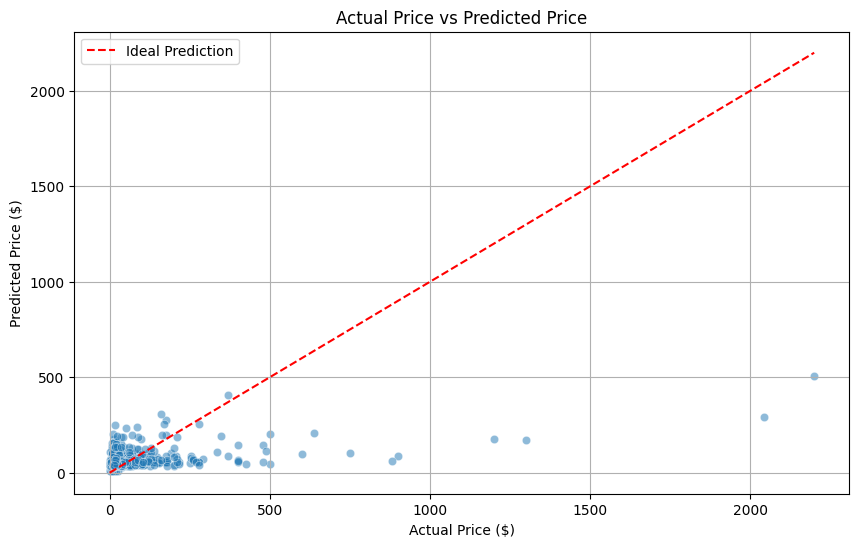

In [17]:
sample_pdf = predictions.select("price", "predicted_price").sample(False, 0.1).limit(1000).toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="price", y="predicted_price", data=sample_pdf, alpha=0.5)

max_val = max(sample_pdf["price"].max(), sample_pdf["predicted_price"].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Ideal Prediction')

plt.title("Actual Price vs Predicted Price")
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.legend()
plt.grid(True)
plt.show()